In [26]:
import pandas as pd
import numpy as np
from collections import defaultdict
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
file_path = 'C:/Users/mertk/Documents/BDA_project/movielens100k/ml-100k/u.data'

df = pd.read_csv(file_path, sep='\t', header=None)

df.columns = ['user_id', 'item_id', 'rating', 'timestamp']

df = df.drop(columns=['timestamp'])

print(df.head())

   user_id  item_id  rating
0      196      242       3
1      186      302       3
2       22      377       1
3      244       51       2
4      166      346       1


In [40]:
df_trainval, df_test = train_test_split(df, test_size=0.2, random_state=42)

df_train, df_val = train_test_split(df_trainval, test_size=0.2, random_state=42)

In [41]:
def compute_rmse(df, P_mat, Q_mat, u_bias, i_bias, global_avg):
    errors = []
    for row in df.itertuples():
        u = row.user_id  
        i = row.item_id 
        r = row.rating
        pred = global_avg + u_bias[u] + i_bias[i] + np.dot(P_mat[u], Q_mat[i])
        err = r - pred
        errors.append(err ** 2)

    return np.sqrt(np.mean(errors))

In [42]:
def filter_known_users_items(df_val, user_map, item_map):
    """Keep only validation rows with users/items seen during training."""
    df_val = df_val.copy()
    df_val['user_id'] = df_val['user_id'].map(user_map)
    df_val['item_id'] = df_val['item_id'].map(item_map)
    return df_val.dropna().astype({'user_id': 'int', 'item_id': 'int'})

In [52]:
def manual_funksvd(df, df_val=None, lr=0.01, reg=0.02, n_epochs=20, n_factors=20, verbose=True):
    
    df = df.copy()

    user_map = {old: new for new, old in enumerate(df['user_id'].unique())}
    item_map = {old: new for new, old in enumerate(df['item_id'].unique())}

    df['user_id'] = df['user_id'].map(user_map) # {'196': 0, '186': 1, '22': 2 ....}
    df['item_id'] = df['item_id'].map(item_map)

    n_users = df['user_id'].nunique()
    n_items = df['item_id'].nunique()

    mu = df['rating'].mean()

    # initialize biases as 0s
    user_bias = np.zeros(n_users)
    item_bias = np.zeros(n_items)

    # initial random values for our item and user matrices
    # normally dist with mean = 0 and std dev = 0.1
    P = np.random.normal(0, 0.1, (n_users, n_factors))
    Q = np.random.normal(0, 0.1, (n_items, n_factors))

    train_rmse_list = []
    val_rmse_list = []

    if df_val is not None:
        df_val_filtered = filter_known_users_items(df_val, user_map, item_map)
    else:
        df_val_filtered = None

    for epoch in range(n_epochs):
        total_loss = 0
        for row in tqdm(df.itertuples(), total=len(df), desc=f"Epoch {epoch+1}"):
            u = row.user_id
            i = row.item_id
            r_ui = row.rating

            pred = mu + user_bias[u] + item_bias[i] + np.dot(P[u], Q[i])
            err = r_ui - pred

            # Update biases e.g; gamma*(e_ui*q_i - lambda*p_u)
            user_bias[u] += lr * (err - reg * user_bias[u])
            item_bias[i] += lr * (err - reg * item_bias[i])

            # Update latent factors  e.g; gamma*(e_ui*q_i - lambda*p_u)
            P[u] += lr * (err * Q[i] - reg * P[u]) # we are updating the same vector like if user_id 166 appeared three times we update the same vector 3 times
            Q[i] += lr * (err * P[u] - reg * Q[i])

            total_loss += err ** 2

        train_rmse = np.sqrt(total_loss / len(df))
        train_rmse_list.append(train_rmse)

        if verbose:
            print(f"Epoch {epoch+1}: Train RMSE={train_rmse:.4f}")

        if df_val_filtered is not None:
            val_rmse = compute_rmse(df_val_filtered, P, Q, user_bias, item_bias, mu)
            val_rmse_list.append(val_rmse)
            if verbose:
                print(f"→ Validation RMSE: {val_rmse:.4f}")

    return P, Q, user_bias, item_bias, mu, user_map, item_map, train_rmse_list, val_rmse_list


In [47]:
P, Q, user_bias, item_bias, mu, user_map, item_map, train_rmse_list, val_rmse_list = manual_funksvd(df_train, 
                                                                                                    df_val, 
                                                                                                    lr = 0.01, 
                                                                                                    reg = 0.02, 
                                                                                                    n_epochs = 20,
                                                                                                    n_factors = 20,
                                                                                                    verbose=True)

Epoch 1: 100%|██████████| 64000/64000 [00:01<00:00, 39582.30it/s]


Epoch 1: Train RMSE=1.0321
→ Validation RMSE: 0.9819


Epoch 2: 100%|██████████| 64000/64000 [00:02<00:00, 26778.87it/s]


Epoch 2: Train RMSE=0.9654
→ Validation RMSE: 0.9617


Epoch 3: 100%|██████████| 64000/64000 [00:03<00:00, 19528.07it/s]


Epoch 3: Train RMSE=0.9443
→ Validation RMSE: 0.9535


Epoch 4: 100%|██████████| 64000/64000 [00:04<00:00, 14301.76it/s]


Epoch 4: Train RMSE=0.9318
→ Validation RMSE: 0.9491


Epoch 5: 100%|██████████| 64000/64000 [00:04<00:00, 13849.06it/s]


Epoch 5: Train RMSE=0.9223
→ Validation RMSE: 0.9464


Epoch 6: 100%|██████████| 64000/64000 [00:03<00:00, 20795.04it/s]


Epoch 6: Train RMSE=0.9139
→ Validation RMSE: 0.9445


Epoch 7: 100%|██████████| 64000/64000 [00:02<00:00, 25850.23it/s]


Epoch 7: Train RMSE=0.9056
→ Validation RMSE: 0.9431


Epoch 8: 100%|██████████| 64000/64000 [00:02<00:00, 25484.35it/s]


Epoch 8: Train RMSE=0.8965
→ Validation RMSE: 0.9419


Epoch 9: 100%|██████████| 64000/64000 [00:02<00:00, 26733.49it/s]


Epoch 9: Train RMSE=0.8863
→ Validation RMSE: 0.9407


Epoch 10: 100%|██████████| 64000/64000 [00:02<00:00, 24682.65it/s]


Epoch 10: Train RMSE=0.8745
→ Validation RMSE: 0.9395


Epoch 11: 100%|██████████| 64000/64000 [00:02<00:00, 26250.08it/s]


Epoch 11: Train RMSE=0.8611
→ Validation RMSE: 0.9385


Epoch 12: 100%|██████████| 64000/64000 [00:02<00:00, 23270.70it/s]


Epoch 12: Train RMSE=0.8463
→ Validation RMSE: 0.9378


Epoch 13: 100%|██████████| 64000/64000 [00:02<00:00, 27363.17it/s]


Epoch 13: Train RMSE=0.8306
→ Validation RMSE: 0.9377


Epoch 14: 100%|██████████| 64000/64000 [00:02<00:00, 27568.15it/s]


Epoch 14: Train RMSE=0.8145
→ Validation RMSE: 0.9383


Epoch 15: 100%|██████████| 64000/64000 [00:02<00:00, 25113.26it/s]


Epoch 15: Train RMSE=0.7984
→ Validation RMSE: 0.9397


Epoch 16: 100%|██████████| 64000/64000 [00:02<00:00, 24659.46it/s]


Epoch 16: Train RMSE=0.7826
→ Validation RMSE: 0.9417


Epoch 17: 100%|██████████| 64000/64000 [00:02<00:00, 24181.11it/s]


Epoch 17: Train RMSE=0.7674
→ Validation RMSE: 0.9443


Epoch 18: 100%|██████████| 64000/64000 [00:02<00:00, 25308.63it/s]


Epoch 18: Train RMSE=0.7527
→ Validation RMSE: 0.9473


Epoch 19: 100%|██████████| 64000/64000 [00:02<00:00, 27869.25it/s]


Epoch 19: Train RMSE=0.7387
→ Validation RMSE: 0.9508


Epoch 20: 100%|██████████| 64000/64000 [00:02<00:00, 28133.50it/s]


Epoch 20: Train RMSE=0.7255
→ Validation RMSE: 0.9544


In [56]:
lr_list = [0.005, 0.01]             
reg_list = [0.01, 0.02]             
n_epoch_list = [20, 50, 75]             
n_factors_list = [20, 30, 50] 

In [53]:
def grid_search(lr_list, reg_list, n_epoch_list, n_factors_list):
    results = []

    best_rmse = 10**10
    best_params = {}

    for lr in lr_list:
        for reg in reg_list:
            for n_epoch in n_epoch_list:
                for n_factor in n_factors_list: 
                    P, Q, user_bias, item_bias, mu, user_map, item_map, train_rmse_list, val_rmse_list = manual_funksvd(df_train, 
                                                                                        df_val, 
                                                                                        lr = lr,
                                                                                        reg = reg, 
                                                                                        n_epochs = n_epoch, 
                                                                                        n_factors = n_factor,
                                                                                        verbose=False)
                    
                    results.append({
                        "factor_number": n_factor,
                        "learning_rate": lr,
                        "regularization": reg,
                        "epochs_trained": n_epoch,
                        "rmse": val_rmse_list[-1]
                    })

                    if val_rmse_list[-1] < best_rmse:
                        best_rmse = val_rmse_list[-1]
                        best_params = {
                            "factor_number": n_factor,
                            "learning_rate": lr,
                            "regularization": reg,
                            "epochs_trained": n_epoch
                        }

    print("\n Best Parameters:")
    print(best_params)
    return best_params, results
                    
                    

In [57]:
best_params, results = grid_search(lr_list, reg_list, n_epoch_list, n_factors_list)

Epoch 1:   0%|          | 0/64000 [00:00<?, ?it/s]

Epoch 75: 100%|██████████| 64000/64000 [00:02<00:00, 29337.25it/s]


 Best Parameters:
{'factor_number': 20, 'learning_rate': 0.005, 'regularization': 0.02, 'epochs_trained': 20}


In [58]:
print(best_params)

{'factor_number': 20, 'learning_rate': 0.005, 'regularization': 0.02, 'epochs_trained': 20}


In [59]:
print(results)

[{'factor_number': 20, 'learning_rate': 0.005, 'regularization': 0.01, 'epochs_trained': 20, 'rmse': 0.9431354873204282}, {'factor_number': 30, 'learning_rate': 0.005, 'regularization': 0.01, 'epochs_trained': 20, 'rmse': 0.9420970302082936}, {'factor_number': 50, 'learning_rate': 0.005, 'regularization': 0.01, 'epochs_trained': 20, 'rmse': 0.9403060925971751}, {'factor_number': 20, 'learning_rate': 0.005, 'regularization': 0.01, 'epochs_trained': 50, 'rmse': 0.9888221822883235}, {'factor_number': 30, 'learning_rate': 0.005, 'regularization': 0.01, 'epochs_trained': 50, 'rmse': 1.0085466136080043}, {'factor_number': 50, 'learning_rate': 0.005, 'regularization': 0.01, 'epochs_trained': 50, 'rmse': 1.011238175331586}, {'factor_number': 20, 'learning_rate': 0.005, 'regularization': 0.01, 'epochs_trained': 75, 'rmse': 1.0364338655163081}, {'factor_number': 30, 'learning_rate': 0.005, 'regularization': 0.01, 'epochs_trained': 75, 'rmse': 1.0551894497639347}, {'factor_number': 50, 'learning_

In [68]:
results_df = pd.DataFrame(results)

results_df.to_csv("grid_search_results.csv", index=False)

In [64]:
P, Q, user_bias, item_bias, mu, user_map, item_map, train_rmse_list, val_rmse_list = manual_funksvd(df_train, 
                                                                                                    df_val, 
                                                                                                    lr = 0.005, 
                                                                                                    reg = 0.02, 
                                                                                                    n_epochs = 20,
                                                                                                    n_factors = 20,
                                                                                                    verbose=True)

Epoch 1: 100%|██████████| 64000/64000 [00:01<00:00, 57346.13it/s]


Epoch 1: Train RMSE=1.0593
→ Validation RMSE: 1.0109


Epoch 2: 100%|██████████| 64000/64000 [00:01<00:00, 48518.59it/s]


Epoch 2: Train RMSE=0.9930
→ Validation RMSE: 0.9818


Epoch 3: 100%|██████████| 64000/64000 [00:01<00:00, 44345.48it/s]


Epoch 3: Train RMSE=0.9674
→ Validation RMSE: 0.9688


Epoch 4: 100%|██████████| 64000/64000 [00:02<00:00, 25028.64it/s]


Epoch 4: Train RMSE=0.9527
→ Validation RMSE: 0.9614


Epoch 5: 100%|██████████| 64000/64000 [00:02<00:00, 21563.84it/s]


Epoch 5: Train RMSE=0.9427
→ Validation RMSE: 0.9565


Epoch 6: 100%|██████████| 64000/64000 [00:03<00:00, 19414.22it/s]


Epoch 6: Train RMSE=0.9350
→ Validation RMSE: 0.9531


Epoch 7: 100%|██████████| 64000/64000 [00:02<00:00, 25023.59it/s]


Epoch 7: Train RMSE=0.9287
→ Validation RMSE: 0.9506


Epoch 8: 100%|██████████| 64000/64000 [00:01<00:00, 35152.44it/s]


Epoch 8: Train RMSE=0.9233
→ Validation RMSE: 0.9486


Epoch 9: 100%|██████████| 64000/64000 [00:01<00:00, 36823.47it/s]


Epoch 9: Train RMSE=0.9184
→ Validation RMSE: 0.9470


Epoch 10: 100%|██████████| 64000/64000 [00:02<00:00, 26919.83it/s]


Epoch 10: Train RMSE=0.9138
→ Validation RMSE: 0.9458


Epoch 11: 100%|██████████| 64000/64000 [00:01<00:00, 43270.74it/s]


Epoch 11: Train RMSE=0.9094
→ Validation RMSE: 0.9447


Epoch 12: 100%|██████████| 64000/64000 [00:02<00:00, 28688.83it/s]


Epoch 12: Train RMSE=0.9050
→ Validation RMSE: 0.9437


Epoch 13: 100%|██████████| 64000/64000 [00:02<00:00, 26485.53it/s]


Epoch 13: Train RMSE=0.9005
→ Validation RMSE: 0.9428


Epoch 14: 100%|██████████| 64000/64000 [00:01<00:00, 33623.22it/s]


Epoch 14: Train RMSE=0.8958
→ Validation RMSE: 0.9420


Epoch 15: 100%|██████████| 64000/64000 [00:01<00:00, 42351.50it/s]


Epoch 15: Train RMSE=0.8909
→ Validation RMSE: 0.9412


Epoch 16: 100%|██████████| 64000/64000 [00:02<00:00, 26363.38it/s]


Epoch 16: Train RMSE=0.8857
→ Validation RMSE: 0.9404


Epoch 17: 100%|██████████| 64000/64000 [00:01<00:00, 38926.07it/s]


Epoch 17: Train RMSE=0.8801
→ Validation RMSE: 0.9397


Epoch 18: 100%|██████████| 64000/64000 [00:02<00:00, 27652.16it/s]


Epoch 18: Train RMSE=0.8742
→ Validation RMSE: 0.9390


Epoch 19: 100%|██████████| 64000/64000 [00:02<00:00, 29292.96it/s]


Epoch 19: Train RMSE=0.8679
→ Validation RMSE: 0.9383


Epoch 20: 100%|██████████| 64000/64000 [00:02<00:00, 28845.87it/s]

Epoch 20: Train RMSE=0.8612
→ Validation RMSE: 0.9377


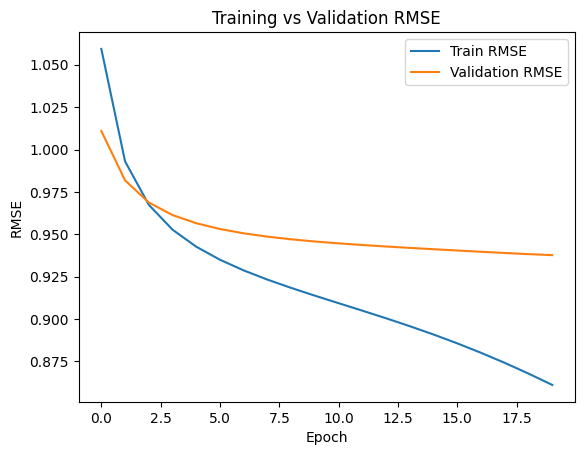

In [65]:
plt.plot(train_rmse_list, label='Train RMSE')
plt.plot(val_rmse_list, label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.title('Training vs Validation RMSE')
plt.show()

In [67]:
df_test_filtered = filter_known_users_items(df_test, user_map, item_map)
test_rmse = compute_rmse(df_test_filtered, P, Q, user_bias, item_bias, mu)

print("Test RMSE:", test_rmse)

Test RMSE: 0.9394707792259133
